## Introduction ##

Cryo-electron microscopy (cryo-EM) is a powerful imaging technique that has transformed structural biology research by enabling high-resolution 3D reconstructions of complex biological macromolecules such as proteins. The process involves collection of tens of thousands of 2D images in a single run, which are then processed using specialized software to generate a detailed 3D model of electron density.

Despite the significant advancements in cryo-EM technology, current reconstruction algorithms, whether traditional or deep learning-based, are time-consuming and require hundreds of thousands of images to achieve high-resolution reconstructions. To accelerate the processing of cryo-EM data for downstream structural biology tasks, innovative methods for 3D reconstruction from 2D output projections are needed.

In this study, we focus on the task of single-particle analysis, where an individual particle is analyzed from 2D images and then reconstructed in 3D space. Our aim is to develop a reconstruction function that preserves the symmetries present in the data by being equivariant to the group SO(3) of 3D rotations. We investigate whether using SO(3)-equivariant neural networks, specifically spherical CNNs, can successfully perform cryo-EM reconstruction. We additionally measure potential improvements in performance and sample efficiency over previous algorithms without compromising the resolution of reconstruction.

## Related Work ##

One of the leading learning-based approaches for cryo-EM reconstruction is cryoDRGN, which leverages a deep generative model of 3D structure from single-particle 2D images [1]. CryoDRGN adopts an image-encoder-volume-decoder architecture, and the model is specified in the Fourier domain to relate 2D images as planar slices in 3D volume. This Fourier-based representation enables the model to efficiently capture detailed particle pose information from images. However, to achieve high-resolution reconstructions, cryoDRGN still requires a large number of images, often in the order of hundreds of thousands. While cryoDRGN is capable of handling heterogeneous reconstructions, where the protein may exhibit different conformational changes across images, we will evaluate its efficacy in our homogeneous reconstruction setting, where we assume all 2D images capture the protein at the same conformational state.
 
Although not used from cryo-EM reconstruction, previous work has demonstrated that 3D object structure and pose can be predicted successfully from a single image using SO(3)-equivariant features [2]. The method, known as Image2Sphere, initially utilizes a vanilla convolutional neural network to extract features that are then projected onto a half-sphere. Next, the projected filter undergoes spherical convolution, which results in a signal that is equivariant to SO(3) rotation. Finally, a group convolution yields a distribution over SO(3) parameterized in the Fourier domain. We plan to employ a similar methodology for our task, but instead of single-image reconstruction, we will focus on multi-view reconstruction.

## Background ##

This project will involve using group convolutions to build up a convolutional neural network which operates on spherical embeddings. This includes concepts surrounding convolutions on SO(3) covered in class (e.g. applying the fourier transform on spherical harmonics). It also includes researching topics beyond the scope of the class such as projections of 2D images onto S2, and building equivariant models which operate directly on spherical embeddings. This project also involves extensive study of 3D reconstruction methods which are outside the scope of the class. Additionally, integrating equivariant methods with the reconstruction algorithms involves combining ideas from symmetry and representation theory with traditional computer vision and graphics methods. 

## Methods ##

We use the Protein Data Bank (PDB) to collect experimentally-determined cryo-EM structures (13375 single-particle data points). For each data point, there is an electron density map in the form of a 3D array as well as 3D coordinates for every residue in the protein. We will use the 3D electron density map to generate m random projections and subsequently add Gaussian noise to the projection images, for use as the 2D images from which we will do reconstruction. The generation and application of synthetic data in this manner for cryo-EM reconstruction algorithm development is common in prior work.


#### Data Generation ####

In [20]:
import pickle
import src.models as models
import src.so3_utils as utils
import numpy as np
import src.projection as proj
import time
import e3nn
from e3nn import o3
import matplotlib.pyplot as plt

We load the data as a dictionary of the form {pdb_id: {"3D_map": np.ndarray, "structure": np.ndarray}}. This dictionary is generated from the raw data csvs (downloaded from rcsb.org) using data_extraction.py

In [13]:
with open('processed_dataset.pickle', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

We then iterate through the dictionary, normalize each electron density map by subtracting the minimum element and dividing by the median, and store each entry as a point density representation (not storing background pixels with no relevant information).

In [14]:
pdrs = {}

for pdb_id, metadata in content.items():
    edm = metadata["3D_map"]
    if np.count_nonzero(edm) > 0.5 * np.size(edm):
        continue
    print(pdb_id)
    cur_time = time.time()
    normalized_edm = proj.normalize_edm(edm)
    print(f"Normalization: {time.time() - cur_time}")
    cur_time = time.time()
    pdr = proj.point_density_representation(normalized_edm)
    print(f"PDR: {time.time() - cur_time}")
    cur_time = time.time()
    pdrs[pdb_id] = pdr

6GL7
Normalization: 13.43444013595581
PDR: 4.353271961212158
6GOV
Normalization: 2.4452521800994873
PDR: 1.0699729919433594


We then generate m (for now, 3) random projections of each PDR. We save these projections into a pickle.

In [2]:
shape = (256, 256)
projection_dict = {}

for pdb_id, pdr in pdrs.items():
    cur_time = time.time()
    random_projs = proj.random_projection(pdr, shape=shape, batch_size = 3)
    print(f"Random projection: {time.time() - cur_time}")
    for projection in random_projs:
        proj.visualize_projection(projection)
    projection_dict[pdb_id] = random_projs

In [17]:
with open('projections.pickle', 'wb') as handle:
    pickle.dump(projection_dict, handle)

#### Projection onto Half-Sphere ####

Our methodology involves projecting each 2D image onto a half sphere as shown in the code below. These spherical signals are an input to a spherical CNN from which we extract features that are spatially local. These learned spherical embeddings should encode pose information, and we plan to experiment with the architecture and parameters of the spherical CNN such that this pose information is well captured. Specifically, we hope to show that these embeddings are empirically equivariant. Specifically, an R degree rotation of a 2D random projection should result in an R degree rotation of the corresponding embedding in the learned spherical latent space.

In [3]:
with open('projections.pickle', 'rb') as pickle_file:
    projection_dict = pickle.load(pickle_file)

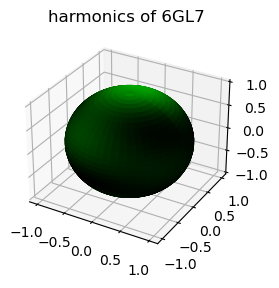

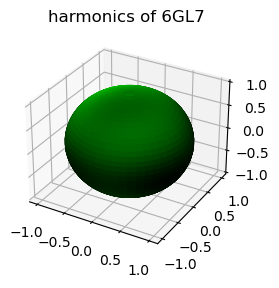

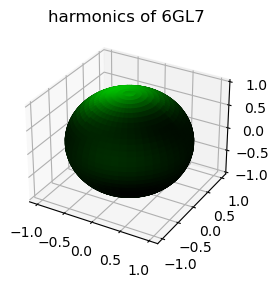

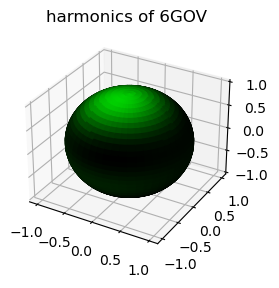

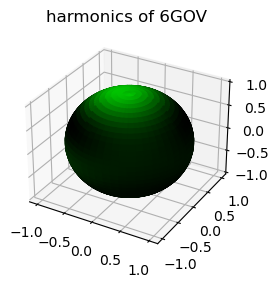

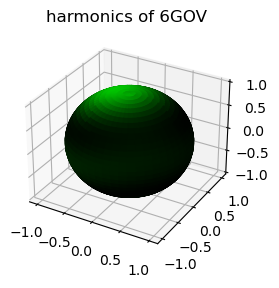

In [4]:
import torch
projector = proj.Image2SphereProjector(fmap_shape=(1,)+shape, sphere_fdim=1, lmax=4)
signals = []
for pdb_id, random_projs in projection_dict.items():
    for fmap in random_projs:
        fmap = torch.from_numpy(np.expand_dims(fmap, axis=0))
        signals.append(proj.visualize_spherical_projection(fmap.float(), projector, pdb_id))

#### Training Spherical CNN ####

We will train a network consisting of S2Conv, SO3Activation, and SO3Conv layers. This is an example of applying these layers (untrained).

In [10]:
lmax=4
s2_fdim=1
so3_fdim=16
s2_kernel_grid = proj.s2_healpix_grid(max_beta=np.inf, rec_level=1)
so3_kernel_grid = utils.so3_near_identity_grid()

s2_conv = models.S2Conv(s2_fdim, so3_fdim, lmax, s2_kernel_grid)
so3_act = e3nn.nn.SO3Activation(lmax, lmax, act=torch.relu, resolution=10)
so3_conv = models.SO3Conv(so3_fdim, 1, lmax, so3_kernel_grid)

In [16]:
sample_signal = signals[0]
print(sample_signal.shape)

x = s2_conv(sample_signal)
x = so3_act(x)
convolved_embedding = so3_conv(x)

torch.Size([1, 1, 25])


In [17]:
print(convolved_embedding.shape)

torch.Size([1, 1, 165])


#### Sketch of Reconstruction Algorithm ####

#### Experiments ####

Our training regime involves using several proteins and randomly simulated projections of the 3D structures onto 2D images. We use simulated data because real cryo-EM image data is often un-processed and spans several terabytes to petabytes in size, which is impractical to use for training. Using simulated images with added noise allows for more efficient training and inference protocols while showing a proof-of-concept of our model architecture.Our model architecture will be based on spherical CNNs used in prior works, as mentioned previously.

During testing, we plan to run several experiments which vary m at inference time, allowing us to measure our model performance as a function of m. This will allow us to provide a tradeoff curve correlating data efficiency versus model accuracy. We also plan to run experiments to understand how our model performance is affected by the amount of noise in samples provided both at training and inference time. To assess the quality of reconstructions, we will compute how close our predicted structure is to the ground truth structure. We will also measure the resolution of our reconstruction for comparison to previous methods.

#### Conclusions ####

We hope to gain a better understanding of how data efficiency of cryo-EM reconstruction can be improved by using equivariant methods. We expect to see an improvement in data efficiency, with tradeoffs in model performance dependent on noise in image samples. We also hope to show how traditional reconstruction methods can be integrated with novel symmetry-preserving methods.

#### References ####

[1] https://www.nature.com/articles/s41592-020-01049-4

[2] https://arxiv.org/pdf/2302.13926.pdf